# Meta-data

In [3]:
#OS libs
import os
import sys
from pathlib import Path
from io import StringIO
#Data handling libs
import pandas as pd
from tqdm import tqdm
from chess.pgn import read_game, BaseVisitor
import chess.engine
#Data visualization libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MultipleLocator, FuncFormatter, LogLocator
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patches as mplp

#Meta-data
dt_pred_folder = os.path.join(os.getcwd(),'dt_chess','datasets_test_predictions_subit')
state_emb_type = 'linear'
predictions = os.listdir(dt_pred_folder)
predictions = [x for x in predictions if x.partition('_')[0] == state_emb_type]
predictions.sort(key=lambda x: int(x.split('_')[1]))
predictions

['linear_0_400_Jiyarkhan.csv',
 'linear_50_400_Jiyarkhan.csv',
 'linear_100_400_Jiyarkhan.csv',
 'linear_150_400_Jiyarkhan.csv',
 'linear_200_400_Jiyarkhan.csv',
 'linear_250_400_Jiyarkhan.csv',
 'linear_300_400_Jiyarkhan.csv',
 'linear_350_400_Jiyarkhan.csv',
 'linear_400_400_Jiyarkhan.csv',
 'linear_450_400_Jiyarkhan.csv',
 'linear_500_400_Jiyarkhan.csv']

## Accuracy

In [16]:
def unique_predictions(pred_file):
    pred_df = pd.read_csv(os.path.join(dt_pred_folder,
                                       pred_file),
                          index_col=None)
    # %% Train data
    train_datasets = os.listdir(os.path.join(os.getcwd(),
                                             'dt_chess',
                                             'datasets'))
    train_data = [x for x in train_datasets if x.partition('_')[0] == pred_file.split('_')[2]][0]
    train_df = pd.read_csv(os.path.join(os.getcwd(),
                                        'dt_chess',
                                        'datasets',
                                        train_data),
                           index_col=(0))
    train_df.rename(columns={'positions': 'board', 'moves': 'move'}, inplace=True)
    train_df.drop_duplicates(inplace=True)
    # Remove duplicates from train data
    pred_df_fin = pd.merge(pred_df, train_df,
                           on=["board","move"], how='left',
                           indicator='Exist')
    #common_total = len(pred_df_fin[pred_df_fin['Exist'] == 'both'])
    pred_df_fin = pred_df_fin[pred_df_fin['Exist'] == 'left_only']
    return pred_df_fin

def get_stats_for_predictions(pred_all_1_df):
    total = len(pred_all_1_df)
    tp1 = len(pred_all_1_df[pred_all_1_df['move'] == pred_all_1_df['engine_move_1']])
    tp2 = len(pred_all_1_df[pred_all_1_df['move'] == pred_all_1_df['engine_move_2']])
    tp3 = len(pred_all_1_df[pred_all_1_df['move'] == pred_all_1_df['engine_move_3']])
    fp = len(pred_all_1_df[pred_all_1_df['illegal_top_move']])
    tn = total - (tp1 + tp2 + tp3)
    tn1 = total - tp1
    return (total, tp1, tp2, tp3, fp, tn, tn1)

def get_stats_for_all_predictions(user_predictions, unique=True, verbose=True):
    stats = []
    pred_list = tqdm(user_predictions) if verbose else user_predictions
    for user_pred_file in pred_list:
        if unique:
            pred_df = unique_predictions(user_pred_file)
        else:
            pred_df = pd.read_csv(os.path.join(dt_pred_folder,
                                               user_pred_file),
                                  index_col=None)
        stats.append(get_stats_for_predictions(pred_df))
    return pd.DataFrame(stats, columns =["total", "tp1", "tp2", "tp3", "fp", "tn", "tn1"])
    
stats_by_it_df = get_stats_for_all_predictions(predictions, unique=True)
stats_by_it_df['acc'] = stats_by_it_df['tp1']/stats_by_it_df['total']*100
stats_by_it_df.insert(0, "iteration", stats_by_it_df.index * 50)
stats_by_it_df.insert(1, "num_positions", stats_by_it_df["iteration"] * 256)
display(stats_by_it_df.style.format(thousands=','))

,iteration,num_positions,total,tp1,tp2,tp3,fp,tn,tn1,acc
0,0,0,"124,610","11,785","6,789","6,337","117,345","99,699","112,825",9.457507
1,50,"12,800","124,591","99,184","5,863","3,274","32,934","16,270","25,407",79.607676
2,100,"25,600","124,586","119,747","3,137",833,"15,750",869,"4,839",96.115936
3,150,"38,400","124,589","123,547",768,112,"5,465",162,"1,042",99.163650
4,200,"51,200","124,588","124,253",218,42,"1,745",75,335,99.731114
5,250,"64,000","124,588","124,505",30,9,599,44,83,99.933380
6,300,"76,800","124,592","124,540",18,6,221,28,52,99.958264
7,350,"89,600","124,589","124,556",11,3,115,19,33,99.973513
8,400,"102,400","124,589","124,564",10,3,66,12,25,99.979934
9,450,"115,200","124,590","124,581",5,1,42,3,9,99.992776


tp1 - Model's number 1 choice is the correct move\
tp2 - Model's number 2 choice is the correct move\
tp3 - Model's number 3 choice is the correct move\
fp - Highest probability in prediction vector is for an illegal move\
tn - The correct move is not in the model's top 3 choices\
tn1 - The correct move is not in the model's number 1 choice\
acc - Model's accuracy

## Train loss

In [5]:
loss_df = pd.read_csv(os.path.join(os.getcwd(),'dt_chess',
                                   'models_subit','linear_400_Jiyarkhan_subit.csv'),
                      header=0)
loss_df.head()

,400_Jiyarkhan
0,8.484516
1,8.329593
2,8.293012
3,8.217455
4,8.175210


In [6]:
print(f"Max train loss: {loss_df.max()[0]:f}\n"
      f"Min train loss: {loss_df.min()[0]:f}")

Max train loss: 8.484516
Min train loss: 0.012304


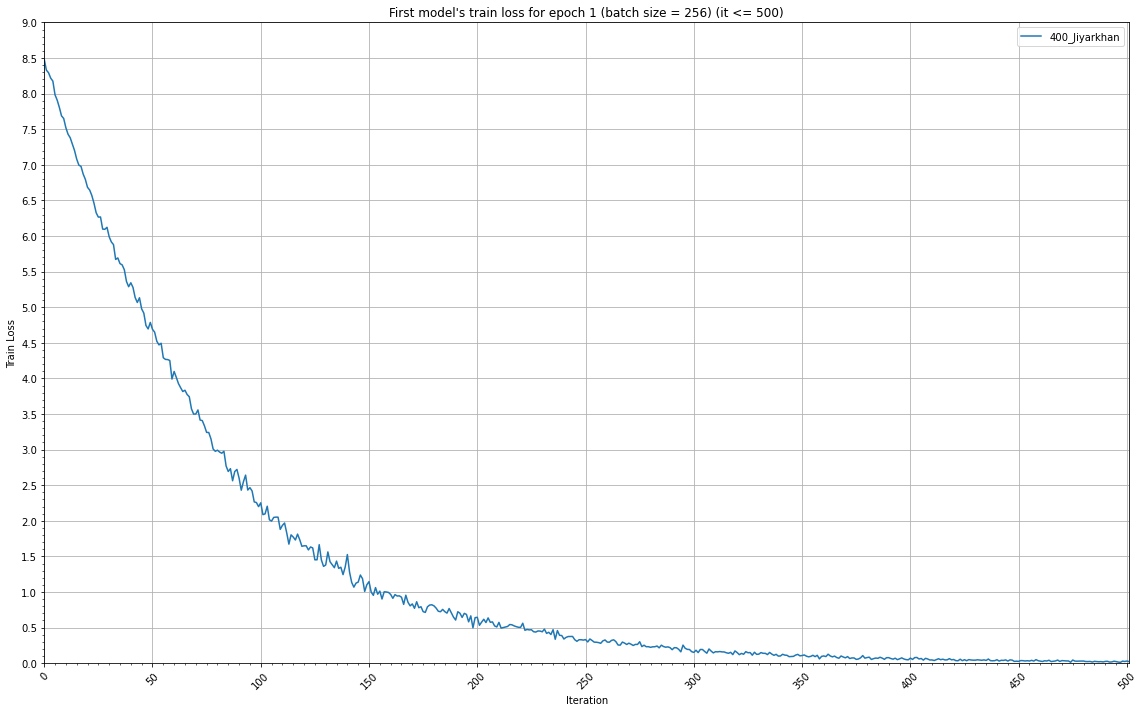

In [18]:
%matplotlib inline
def round_up(x, base=5):
    result = x + ((base - x) % base)
    # In this perticular case hard cap to 100
    # because we are working with accuracy
    if result > 100:
       result = 100
    return result

#PDF plot
plt.figure(figsize=(16, 10))
ax = sns.lineplot(data = loss_df)
ax.set(xlabel='Iteration')
ax.set(ylabel='Train Loss')
#Set major and minor ticks
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(axis='y', which='both', left=True)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(axis='x', which='both', bottom=True)
ax.tick_params(axis="x", which="both", rotation=45)
#Extend y-limits
plt.ylim(0,round_up(loss_df.max()[0],1))
#Tighted x-limits
plt.xlim(0,len(loss_df)-1)
#Set grid
plt.grid(visible = True, which = 'major', axis = 'y', linestyle = '-',zorder=0)
plt.grid(visible = True, which = 'major', axis = 'x', linestyle = '-',zorder=0)
plt.title(f"First model's train loss for epoch 1 (batch size = 256) (it <= 500)")
plt.tight_layout()
plt.show()